In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy.random import rand
import pandas as pd
import copy
import tqdm

from simulation_functions import run_simulation

In [3]:
elements = 10000

rand_FWHM = (rand(elements) * 3) + 3
rand_radius = (rand(elements) * 6) + 7
rand_A = (rand(elements) * 40)

data = run_simulation(rand_FWHM, rand_radius, rand_A)

Simulating 10000 points
Launching 6 threads 



100%|██████████| 10000/10000 [01:47<00:00, 92.71it/s]



All threads completed! Total time: 0 h, 1 min, 51 s


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim



df_train = data.dropna().sample(frac=0.8, random_state=0)
df_test = data.dropna().drop(df_train.index)

train_labels = df_train.pop("A_true")
test_labels = df_test.pop("A_true")

In [30]:
x_train = torch.tensor(df_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(train_labels.to_numpy(),dtype=torch.float32).reshape(-1, 1)

x_test = torch.tensor(df_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(test_labels.to_numpy(),dtype=torch.float32).reshape(-1, 1)
print(x_train.shape, y_train.shape)

torch.Size([8000, 11]) torch.Size([8000, 1])


In [31]:

model = nn.Sequential(
    nn.Linear(11, 64),
    nn.ReLU(),
    # nn.Linear(64, 64),
    # nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)



In [32]:
# loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 50   # number of epochs to run
batch_size = 10  # size of each batch

In [33]:
batch_start = torch.arange(0, len(x_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in tqdm.trange(n_epochs, disable = False, unit="epochs"):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description("Epoch {:>3}".format(epoch))
        for start in bar:
            # take a batch
            X_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad() # Reset gradient
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(x_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


MSE: 0.1095
RMSE: 0.3309


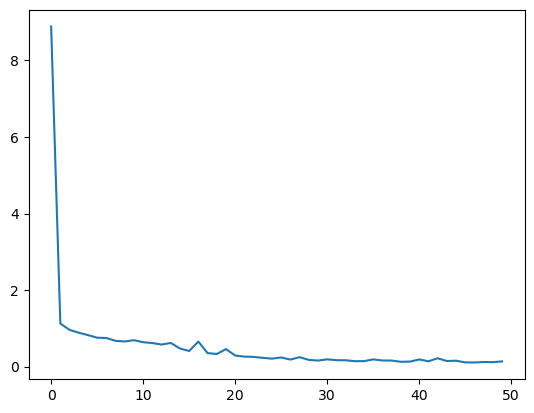

In [34]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.4f" % best_mse)
print("RMSE: %.4f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

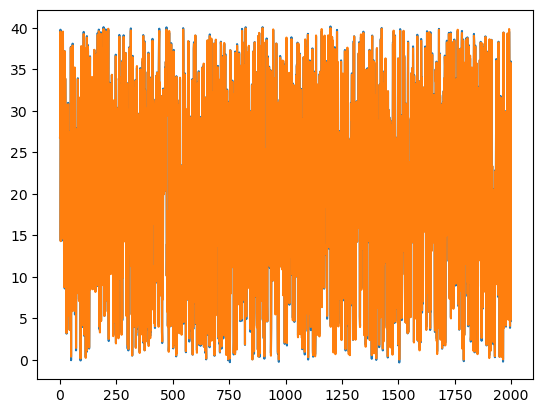

In [35]:
model.eval()
prediction = model(x_test)

with torch.no_grad():
    plt.plot(range(len(prediction.reshape(-1))), prediction)
    plt.plot(range(len(prediction.reshape(-1))), y_test)